In [121]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
from yellowbrick.cluster import KElbowVisualizer
from itertools import permutations
from scipy.spatial.distance import cdist

import pickle
from datetime import datetime

import json

In [122]:
# Import the dataset containing all the electronic music genres
df = pd.read_csv('../../data/clean_data/electronic_dataset.csv')

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           5826 non-null   object 
 1   playlist_url       5826 non-null   object 
 2   playlist_name      5826 non-null   object 
 3   track_name         5826 non-null   object 
 4   track_popularity   5826 non-null   int64  
 5   artist_name        5826 non-null   object 
 6   album              5826 non-null   object 
 7   album_cover        5826 non-null   object 
 8   artist_genres      5826 non-null   object 
 9   artist_popularity  5826 non-null   int64  
 10  danceability       5825 non-null   float64
 11  energy             5825 non-null   float64
 12  key                5825 non-null   float64
 13  loudness           5825 non-null   float64
 14  mode               5825 non-null   float64
 15  speechiness        5825 non-null   float64
 16  acousticness       5825 

In [124]:
# Since we just have one row with missing values, we have decided to drop it
df.dropna(inplace=True)

In [125]:
df.head()

,track_id,playlist_url,playlist_name,track_name,track_popularity,artist_name,album,album_cover,artist_genres,artist_popularity,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,3FnaCm5NYQh8prhCfPDNOV,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Promised,42,Pig&Dan,Promised,https://i.scdn.co/image/ab67616d0000b273510295...,"['dark techno', 'microhouse', 'minimal techno'...",41,...,1.0,0.0400,0.026700,0.87800,0.0854,0.0367,124.005,562229.0,4.0,techhouse
1,3oJaIce9FdZyKlpQ22jxp5,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Dark Matter,47,Dubfire,Dark Matter / Dust & Gas,https://i.scdn.co/image/ab67616d0000b273d6c80d...,"['deep minimal techno', 'minimal techno', 'tec...",43,...,1.0,0.0767,0.000703,0.88600,0.0721,0.1240,131.999,530496.0,4.0,techhouse
2,50MkrUXSXsS1Q1bn95XQcm,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Sleepless - Stephan Bodzin Remix,48,Pan-Pot,The Other Remixes,https://i.scdn.co/image/ab67616d0000b27379a15e...,"['german techno', 'microhouse', 'minimal techn...",40,...,1.0,0.0462,0.000220,0.81100,0.0869,0.0845,119.991,540000.0,4.0,techhouse
3,2hJRfyYiJ8umxp1WdbeyLj,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,Dubmission - 2021 Edit,51,Anja Schneider,Dubmission (Original Edit),https://i.scdn.co/image/ab67616d0000b2730b9874...,"['electra', 'german house', 'german techno', '...",44,...,1.0,0.0947,0.335000,0.89100,0.0971,0.2760,122.033,186885.0,4.0,techhouse
4,1BpG59DLyW6jZxN2PYiUA3,https://open.spotify.com/playlist/7HxEKL4NF7ZK...,The Sound of Tech House,2daBeat,47,Super Flu,Musik 3,https://i.scdn.co/image/ab67616d0000b273f2fcdb...,"['deep euro house', 'german house', 'microhous...",43,...,0.0,0.0687,0.109000,0.00864,0.0836,0.2210,120.022,329787.0,4.0,techhouse


In [126]:
# We drop the unnecessary columns for this project
df.drop(['album_cover', 'track_id', 'playlist_url', 'playlist_name'], axis=1, inplace=True)

In [127]:
# # Some of the and albums of the tracks have extra information added after a '-' or in between '()'
df['album'] = df['album'].str.split('(').str[0]
df['album'] = df['album'].str.split('-').str[0]

In [128]:
# Since every electronic music genre has a specific tempo ratio, we have created a function to remove the
# Rows which have tempo outside of that threshold

def filter_tempo(data, genre, max_val, min_val):
    tempo = df.loc[df.genre == genre, 'tempo']
    
    above_threshold = tempo[tempo > max_val].index.tolist()
    below_threshold = tempo[tempo < min_val].index.tolist()
    indexNames = above_threshold + below_threshold
    
    data.drop(indexNames, inplace=True)

In [129]:
filter_tempo(df, 'ambient', 100, 0)
filter_tempo(df, 'synthwave', 140, 80)
filter_tempo(df, 'psytrance', 170, 120)
filter_tempo(df, 'techno', 150, 125)
filter_tempo(df, 'trance', 155, 125)
filter_tempo(df, 'dnb', 185, 160)
filter_tempo(df, 'hardstyle', 165, 140)
filter_tempo(df, 'techhouse', 125, 120)
filter_tempo(df, 'trap', 165, 135)

In [130]:
# We have lost some data but we have gained in accuracty 
df['genre'].value_counts()

psytrance    580
techhouse    563
techno       543
trance       502
hardstyle    426
synthwave    395
ambient      385
dnb          338
trap         287
Name: genre, dtype: int64

In [131]:
# We need to encode the categorical variables, we have used manual encoding for the genres so we can control the result
le = preprocessing.LabelEncoder()

df["artist_encoded"] = le.fit_transform(df["artist_name"])
df["album_encoded"] = le.fit_transform(df["album"])

genre_encoded_dict = {'ambient' : 1,
                      'psytrance' : 2,
                      'dnb' : 3,
                      'hardstyle' : 4,
                      'trance' : 5,
                      'techno' : 6,
                      'techhouse' : 7,
                      'trap' : 8,
                      'synthwave' : 9}

df.genre = df.genre.map(genre_encoded_dict)

<AxesSubplot:xlabel='artist_popularity'>

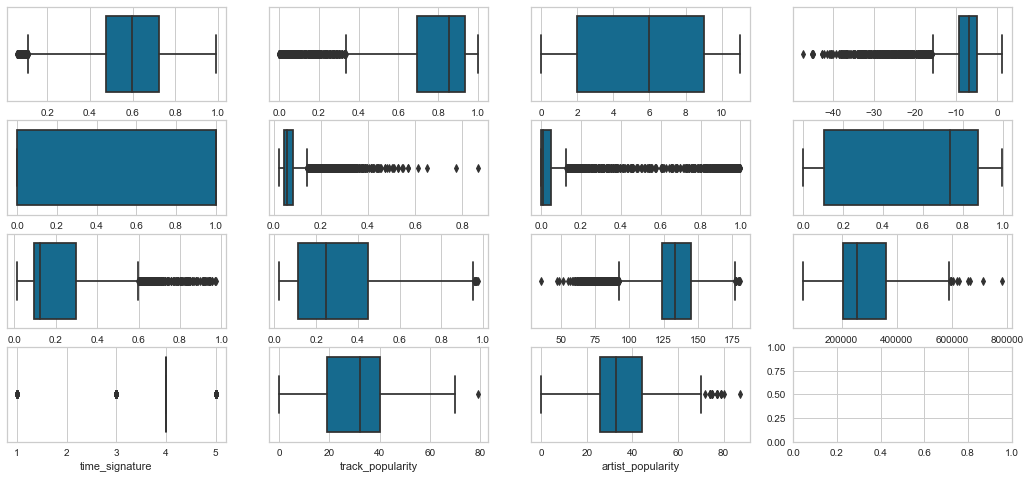

In [132]:
# Using boxplots, we have observed the presence of outliers in our data. We have tried  to remove them with 
# windsorizing, but it hasn't affected the correlation of the features

fig, axes = plt.subplots(4, 4, figsize=(18, 8))
 
sns.boxplot(ax=axes[0, 0], x = df['danceability'])
sns.boxplot(ax=axes[0, 1], x = df['energy'])
sns.boxplot(ax=axes[0, 2], x = df['key'])
sns.boxplot(ax=axes[0, 3], x = df['loudness'])
sns.boxplot(ax=axes[1, 0], x = df['mode'])
sns.boxplot(ax=axes[1, 1], x = df['speechiness'])
sns.boxplot(ax=axes[1, 2], x = df['acousticness'])
sns.boxplot(ax=axes[1, 3], x = df['instrumentalness'])
sns.boxplot(ax=axes[2, 0], x = df['liveness'])
sns.boxplot(ax=axes[2, 1], x = df['valence'])
sns.boxplot(ax=axes[2, 2], x = df['tempo'])
sns.boxplot(ax=axes[2, 3], x = df['duration_ms'])
sns.boxplot(ax=axes[3, 0], x = df['time_signature'])
sns.boxplot(ax=axes[3, 1], x = df['track_popularity'])
sns.boxplot(ax=axes[3, 2], x = df['artist_popularity'])

<AxesSubplot:>

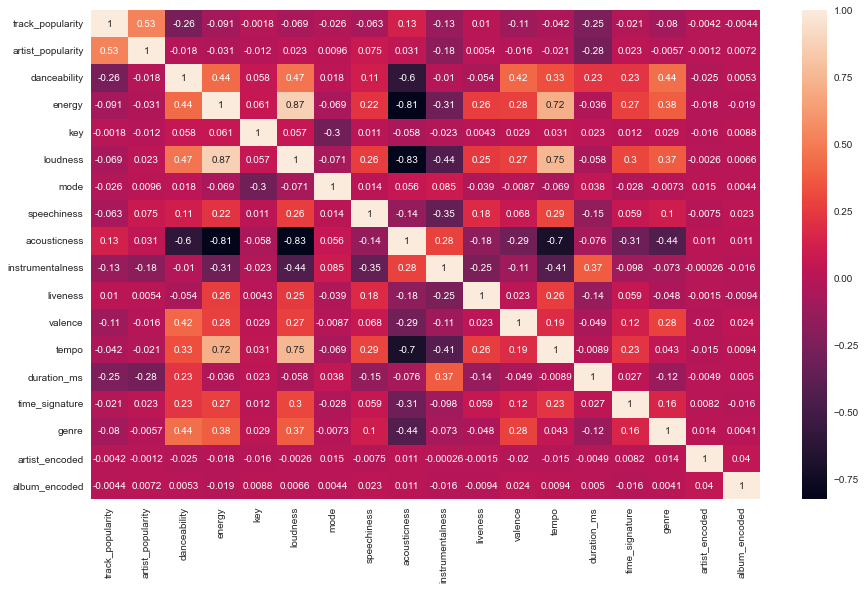

In [133]:
plt.figure(figsize =(15, 9))
sns.heatmap(df.corr(), annot=True)

In [134]:
# In order to have a equal distribution of our variables, we have applied logaritmic transformation

df['artist_popularity'] = np.log1p(df.artist_popularity)
df['track_popularity'] = np.log1p(df.track_popularity)
df['key'] = np.log1p(df.key)
df['tempo'] = np.log1p(df.tempo)
df['duration_ms'] = np.log1p(df.duration_ms)
df['time_signature'] = np.log1p(df.time_signature)
df['artist_encoded'] = np.log1p(df.artist_encoded)
df['album_encoded'] = np.log1p(df.album_encoded)

In [135]:
# Once our data has been cleaned, we will start testing different models and adjusts
# First we divide our data, we will drop some columns, like the album or the artist (encoded). 
# We have also dropped some numerical features like the time signature, the key and the mode.

X = df[['track_popularity', 'artist_popularity', 'danceability', 'energy', 'loudness', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=123)

In [136]:
# We have also applied a Min Max Scaler transformation over our features variable, in order to normalize our data

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [146]:
# filename = 'scaler'
# path = '../../models/' + filename
# with open(path, 'wb') as archivo_salida:
#     pickle.dump(scaler, archivo_salida)

In [138]:
# We have tested Random Forest Classifier model with different params, and these are the ones that gave the best results
# We have also tested our accuracy, recall and score

rf1 = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf1.fit(X_train, y_train)

rf1_pred = rf1.predict(X_test)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, rf1_pred))
print("RECALL OF THE MODEL: ", metrics.recall_score(y_test, rf1_pred, average='macro'))
print("SCORE IN TEST: ", rf1.score(X_test, y_test))
print("SCORE IN TRAIN: ", rf1.score(X_train, y_train))

ACCURACY OF THE MODEL:  0.917910447761194
RECALL OF THE MODEL:  0.9152675503373549
SCORE IN TEST:  0.917910447761194
SCORE IN TRAIN:  0.9975116640746501


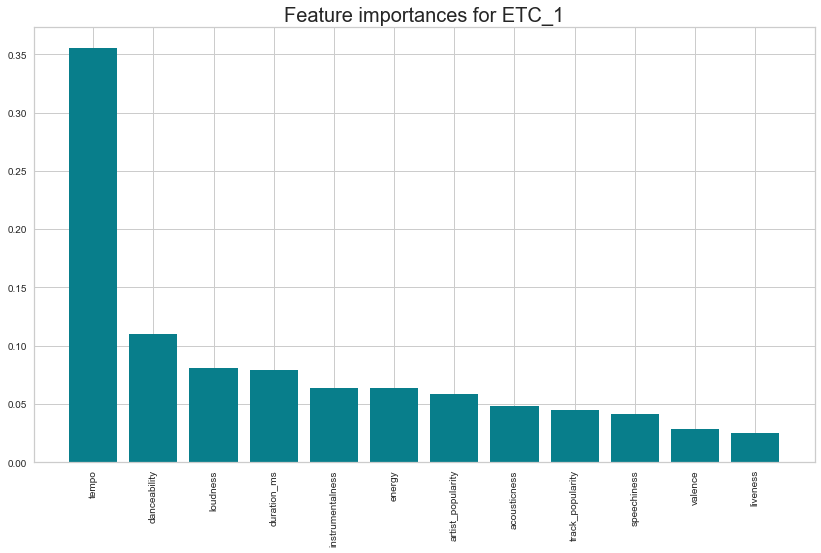

In [139]:
# In order to observe which have been the most important features, we visualize the feature importance with a plot

importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': rf1.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (14,8))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances for ETC_1', size=20)
plt.xticks(rotation='vertical')
plt.show()

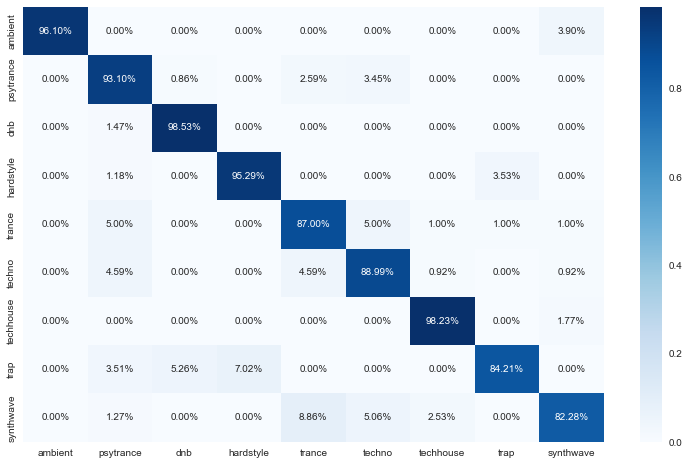

In [140]:
# From the confusion matrix we can observe that the classes which got the worst classification, have been 
# trance, techno and synthwave

x_axis_labes = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
y_axis_labels = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
plt.figure(figsize=(13,8))
sns.heatmap(confusion_matrix(y_test, rf1_pred, normalize='true', labels=np.unique(y_test)), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=x_axis_labes, yticklabels=y_axis_labels);

In [141]:
# In order to try to improve our resaults, we have tested SMOTE, a random oversampler
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)

In [142]:
# After testing with the model, our accuracy has improved a lot, but it can be also due to overf2itting

rf2 = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf2.fit(X_train_smote, y_train_smote)

rf2_pred = rf2.predict(X_test)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, rf2_pred))
print("RECALL OF THE MODEL: ", metrics.recall_score(y_test, rf2_pred, average='macro'))
print("SCORE IN TEST: ", rf2.score(X_test, y_test))
print("SCORE IN TRAIN: ", rf2.score(X_train_smote, y_train_smote))

ACCURACY OF THE MODEL:  0.9116915422885572
RECALL OF THE MODEL:  0.9119922074495561
SCORE IN TEST:  0.9116915422885572
SCORE IN TRAIN:  0.9985632183908046


In [143]:
# We will try now undersampling, since it's a safer technique, and see if we also get good resaults.
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

In [144]:
# Undersampling has given us better resaults, as we can see in the accuracy
rf3 = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf3.fit(X_train_rus, y_train_rus)

rf3_pred = rf3.predict(X_test)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, rf3_pred))
print("RECALL OF THE MODEL: ", metrics.recall_score(y_test, rf3_pred, average='macro'))
print("SCORE IN TEST: ", rf3.score(X_test, y_test))
print("SCORE IN TRAIN: ", rf3.score(X_train_rus, y_train_rus))

ACCURACY OF THE MODEL:  0.9092039800995025
RECALL OF THE MODEL:  0.9102687644239735
SCORE IN TEST:  0.9092039800995025
SCORE IN TRAIN:  0.9985507246376811


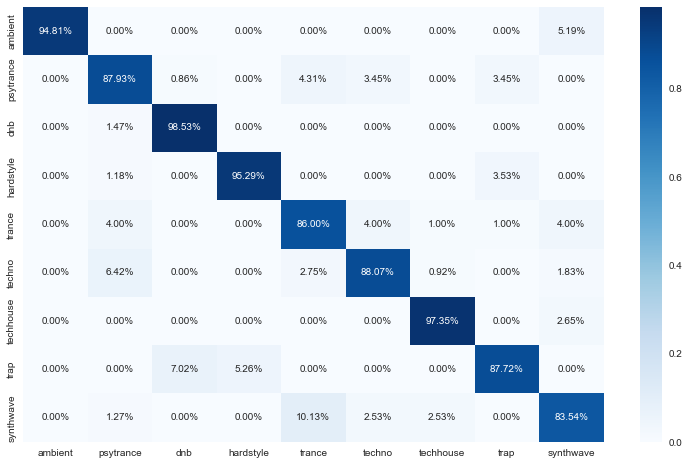

In [145]:
# It has also solved the unbalancing of the classification in techno, trance and synthwave
# This will be the model we will use of our project
x_axis_labes = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
y_axis_labels = ['ambient', 'psytrance', 'dnb', 'hardstyle', 'trance', 'techno', 'techhouse', 'trap', 'synthwave']
plt.figure(figsize=(13,8))
sns.heatmap(confusion_matrix(y_test, rf3_pred, normalize='true', labels=np.unique(y_test)), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=x_axis_labes, yticklabels=y_axis_labels);

In [148]:
#This code will be used to save the desired data as a train and test csv files

# train_data = X_train
# train_data['genre'] = y_train
# test_data = X_test
# test_data['genre'] = y_test
# train_data.to_csv('../../data/train.csv', index=False)
# test_data.to_csv('../../data/test.csv', index=False)

In [147]:
#The code below will be used to save our model into the specific folder

# filename = 'my_model'
# # date = str(datetime.today().strftime('%y%m%d%H%M%S'))
# # name = filename + date
# path = '../../models/' + filename
# with open(path, 'wb') as archivo_salida:
#     pickle.dump(rf1, archivo_salida)

In [54]:
# We will try now to test unsupervised learning, usingg clustering in order go create groups within the tracks,
# and see if there's a clear division. For this, we will use both the train and the test data.

X_train = pd.read_csv('../../data/train.csv')
X_train.drop(['genre'], axis=1)

X_test = pd.read_csv('../../data/test.csv')

X_all = pd.concat([X_train, X_test])

X = X_all.drop(['genre'], axis=1)

In [55]:
# This will help us to visually observe how many cluster will we need

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15, 1)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

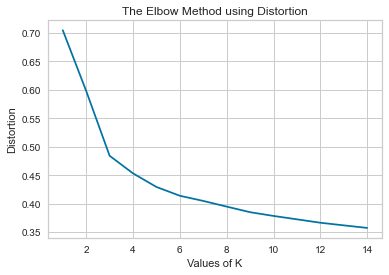

In [56]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

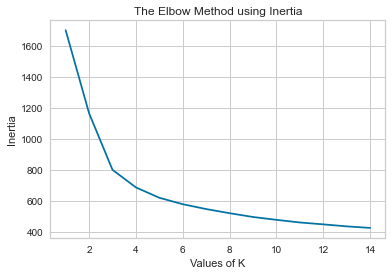

In [57]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [59]:
# From the visualization we can clearly see the cluster of 'ambient', which was already quite different in the EDA

kmeans = KMeans(init="k-means++",
                n_clusters=9,
                random_state=15,
                max_iter = 500).fit(X)

X['kmeans'] = kmeans.labels_

fig = px.scatter_3d(X, x='energy', y='instrumentalness', z='loudness',
              color='kmeans')
fig.show()

In [61]:
# We add the genre column, which is our target, so we can plot the results of our clustering
# For this we also need to decode our genres

col_list = X_all.genre.values.tolist()

X['genre'] = col_list

genre_decode_dict = {1 : 'ambient',
                 2 : 'psytrance',
                 3 : 'dnb',
                 4 : 'hardstyle',
                 5 : 'trance',
                 6 : 'techno',
                 7 : 'techhouse',
                 8 : 'trap',
                 9 : 'synthwave'}

X.genre = X.genre.map(genre_decode_dict)

<AxesSubplot:xlabel='genre', ylabel='count'>

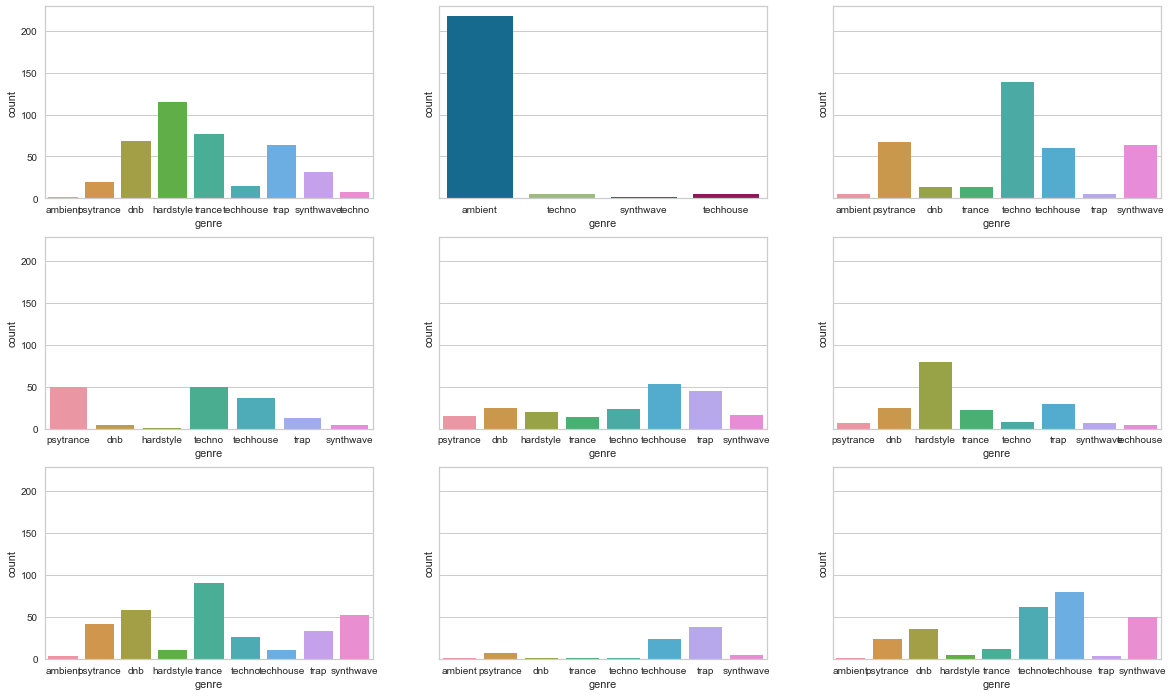

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,12), sharey=True)

df = X
mask = (df['kmeans'] == 0)
df_0 = df[mask]
sns.countplot(x=df_0["genre"], ax=axes[0,0])

df = X
mask = (df['kmeans'] == 1)
df_1 = df[mask]
sns.countplot(x=df_1["genre"], ax=axes[0,1])

df = X
mask = (df['kmeans'] == 2)
df_2 = df[mask]
sns.countplot(x=df_2["genre"], ax=axes[0,2])

df = X
mask = (df['kmeans'] == 3)
df_3 = df[mask]
sns.countplot(x=df_3["genre"], ax=axes[1,0])

df = X
mask = (df['kmeans'] == 4)
df_4 = df[mask]
sns.countplot(x=df_4["genre"], ax=axes[1,1])

df = X
mask = (df['kmeans'] == 5)
df_5 = df[mask]
sns.countplot(x=df_5["genre"], ax=axes[1,2])

df = X
mask = (df['kmeans'] == 6)
df_6 = df[mask]
sns.countplot(x=df_6["genre"], ax=axes[2,0])

df = X
mask = (df['kmeans'] == 7)
df_7 = df[mask]
sns.countplot(x=df_7["genre"], ax=axes[2,1])

df = X
mask = (df['kmeans'] == 8)
df_8 = df[mask]
sns.countplot(x=df_8["genre"], ax=axes[2,2])

After visualizing the clusters, we can see that the only genre that it has predicted properly, it's the ambient.
Therefore, we won't be moving forward with this classification and will keep the Random Forest Classifier as the final model.